<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="400" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr />

# <h1 align="center"> Deep Learning & Tensorflow: CNN Tutorial with Transfer Learning (Helper Notebook 1) </h1> </center>

<p style="margin-bottom:1cm;"></p>

_____

<center>Constructor Academy, 2024</center>

# Helper Notebook 1

__Part 1: Running a vanilla Resnet 50 model__


The tutorial has been adapted from

https://github.com/Hvass-Labs/TensorFlow-Tutorials

## Introduction


In class we learnt that transfer learning (even on highly unrelated datasets) can be a good starting point to train deep image classifiers. In this tutorial we look at ResNet-50, a pre-trained convolution neural network. Here we will explore its architecture, its functionality and how we can use it for image classification.




<img src='https://i.stack.imgur.com/I5nj1.png' width=600>


## Task


In this notebook, we will run a vanilla Resnet 50 model without any transfer learning or fine tuning. Our goal is to see how this pre-trained model works with our butterfly dataset.

## ResNet-50 - What are you?


Before we dive into the coding section, lets look at the model we are using today.

Deeper neural networks are more difficult to train.
The first main issue that arises is with vanishing and exploding gradients.
This is managed for networks with tens of layers by intermittently inserting normalization layers (The normalization layer applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. i.e. the values at the nodes are normalized to stay close to the range of 0 $\pm$ 1 )


The Resnet 50 architecture uses a residual learning framework to ease the training of networks that are substantially deeper than those used
previously.


<img src="https://cdn-images-1.medium.com/fit/t/1600/480/0*tH9evuOFqk8F41FG.png" width=100% class="center">
<center> <h1>  </h1> </center>


## Import libraries

In [ ]:
import pandas as pd
import tempfile
import os
import glob


#------------tensoflow libraries-----------------
import tensorflow as tf


In [ ]:
print('tensorflow version: ', tf.__version__)
print('GPUs available: {}'.format(tf.config.list_physical_devices('GPU')))

tensorflow version:  2.17.1
GPUs available: []


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15119486147147251756
xla_global_id: -1
]


## Load data and helper functions

In [ ]:
!gdown 13ApP1oYLi6AsJ6sBctvC1tkmBG9MAmbz -O butterflies_sample.zip # sample data set

Downloading...
From (original): https://drive.google.com/uc?id=13ApP1oYLi6AsJ6sBctvC1tkmBG9MAmbz
From (redirected): https://drive.google.com/uc?id=13ApP1oYLi6AsJ6sBctvC1tkmBG9MAmbz&confirm=t&uuid=23e74e65-3699-4e0e-93be-ce4eff2564bb
To: /content/butterflies_sample.zip
100% 527M/527M [00:15<00:00, 33.1MB/s]


In [ ]:
!unzip -q butterflies_sample.zip

In [ ]:
!ls butterflies_sample

helper_cnn.py  images  splits


In [ ]:
import butterflies_sample.helper_cnn as hp

In [ ]:
def df_from_json(json_path, image_path):
  tdf = pd.read_json(json_path, orient='index')
  tdf['image_name'] = tdf['image_path'] + '/' + tdf['image_name']
  tdf['species'] = tdf['genus'] + '_' + tdf['specific_epithet']

  image_path = os.path.join(image_path, '')
  list_image_paths = glob.glob(image_path+'*/*.JPG')
  list_image_paths = [x.replace(image_path,'') for x in list_image_paths]
  check_image_bool = tdf['image_name'].apply(lambda x: x in list_image_paths)
  tdf = tdf[check_image_bool]

  print('loaded {}.json with shape {}'.format(json_path, tdf.shape))
  return tdf

In [ ]:
images_dir = "butterflies_sample/images"

df_train = df_from_json("butterflies_sample/splits/train.json", images_dir)
df_val = df_from_json("butterflies_sample/splits/val.json", images_dir)
df_test = df_from_json("butterflies_sample/splits/test.json", images_dir)

loaded butterflies_sample/splits/train.json.json with shape (884, 16)
loaded butterflies_sample/splits/val.json.json with shape (56, 16)
loaded butterflies_sample/splits/test.json.json with shape (63, 16)


In [ ]:
dataframes = [df_train, df_val, df_test]

data = pd.concat(dataframes)
print(data.shape)
data.head(2)

(1003, 16)


author  \
b896e0a5-3ec1-4b7d-9568-3f85f6757786                (Linnaeus, 1758)   
ef6d5359-4232-42cb-a8a1-6475ce8c940a  (Denis & Schiffermüller, 1775)   

                                              barcode      country   dec_lat  \
b896e0a5-3ec1-4b7d-9568-3f85f6757786  ETHZ-ENT0004492  Switzerland  46.58001   
ef6d5359-4232-42cb-a8a1-6475ce8c940a  ETHZ-ENT0032471  Switzerland  46.33484   

                                      dec_long       family     genus  \
b896e0a5-3ec1-4b7d-9568-3f85f6757786   7.38819  Hesperiidae   Erynnis   
ef6d5359-4232-42cb-a8a1-6475ce8c940a   7.62192  Nymphalidae  Melitaea   

                                                                        image_name  \
b896e0a5-3ec1-4b7d-9568-3f85f6757786  2017_03_06R/ETHZ_ENT01_2017_03_06_001080.JPG   
ef6d5359-4232-42cb-a8a1-6475ce8c940a  2017_05_23R/ETHZ_ENT01_2017_05_23_032986.JPG   

                                       image_path infraspecific_epithet  \
b896e0a5-3ec1-4b7d-9568-3f85f6757786  2017_03_06R                  None   
ef6d5359-4232-42cb-a8a1-6475ce8c940a  2017_05_23R                  None   

                                     primary_division specific_epithet  \
b896e0a5-3ec1-4b7d-9568-3f85f6757786             Bern            tages   
ef6d5359-4232-42cb-a8a1-6475ce8c940a           Valais           phoebe   

                                        subfamily subspecific_epithet  \
b896e0a5-3ec1-4b7d-9568-3f85f6757786     Pyrginae                None   
ef6d5359-4232-42cb-a8a1-6475ce8c940a  Nymphalinae                None   

                                                                     token  \
b896e0a5-3ec1-4b7d-9568-3f85f6757786  b896e0a5-3ec1-4b7d-9568-3f85f6757786   
ef6d5359-4232-42cb-a8a1-6475ce8c940a  ef6d5359-4232-42cb-a8a1-6475ce8c940a   

                                              species  
b896e0a5-3ec1-4b7d-9568-3f85f6757786    Erynnis_tages  
ef6d5359-4232-42cb-a8a1-6475ce8c940a  Melitaea_phoebe

##  Modeling: Pre-Trained Model-ResNet-50

The following creates an instance of the Resnet-50 model pre-trained on the ImageNet dataset. This automatically downloads the required files if you don't have them already.


<img src="https://www.researchgate.net/publication/349717475/figure/fig4/AS:996933933993986@1614698980245/The-architecture-of-ResNet-50-model.ppm" width=900 class="center">


The Resnet model contains blocks of convolutional layers to extract features and a classfication head, or top, which contains an average pooling layer and a fully-connected (or dense) layer. If `include_top=True` then the whole model is initialized. If `include_top=False` then only the convolutional part of the model is initialized.

The keyword argument `weights='imagenet` loads the model with weights that have been pretrainined on the imagenet dataset. This is much faster to train than initializing a model with randomly assigned weights

You can also load other pretrained models e.g. VGG, ResNet, DenseNet  available at
- https://www.tensorflow.org/api_docs/python/tf/keras/applications


A full tutorial using RestNet50
- https://heartbeat.fritz.ai/how-to-fine-tune-resnet-in-keras-and-use-it-in-an-ios-app-via-core-ml-ee7fd84c1b26

## Creating ResNet-50 instance


In [ ]:
model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),
                                                  include_top=True,
                                                  weights='imagenet'
                                                        )

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model architecture


In [ ]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

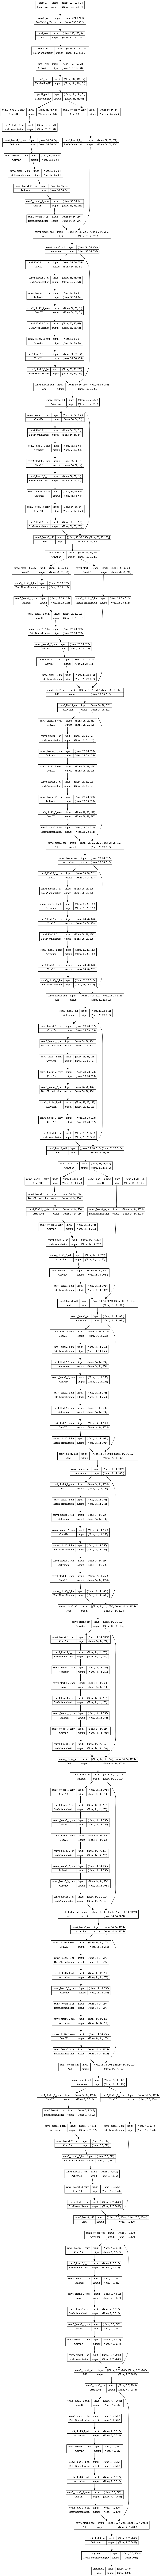

In [ ]:
# tempfile_path = os.path.join(tempfile.mkdtemp(),'resnet50_model.png')
# tf.keras.utils.plot_model(model, tempfile_path, show_shapes=True)

## Input Pipeline


When we initiliazed the model we set the shape of the input for the first layer to handle. Any input to the model, like for a new prediction, needs to be **resized** to this shape before it is passed to the model. Otherwise the misaligned shapes will cause an error.

In this case it is images of shape 224 x 224 x 3.
The code `model.layers[0].output_shape[0]` gets the shape of the first layer in the model.
These dimensions can be understood as:
- None = batch_size
- 224 = height
- 224 = width
- 3 = number of channels

In [ ]:
print(model.layers[0].output.shape)
input_shape = model.layers[0].output.shape[1:3]
input_shape

(None, 224, 224, 3)


(224, 224)

## Example Predictions


Here a few examples of using the pre-trained model for prediction are shown.

A helper-function for loading and resizing an image is needed, so that the image can work as an input to the model, along with doing the actual prediction and show the result.

We can then use the model on a picture from our training data. Though model is not trained on images from our data, one can still appreciate the power of this network in identifying the images based on the data it was trained on.


In [ ]:
# For the sake of computational efficiency (especially for running on Colab),
# we will just try to predict the family (more general than the species)
# and will limit the the number of training images per class.

x_col = 'image_name' # column in the df with local paths to images
y_col = "family" # column in the df with the names of the classes

print("'{}' column contains {} unique classes".format(y_col, data[y_col].unique().shape[0] ))

'family' column contains 6 unique classes


In [ ]:
# Family classes

list(data[y_col].unique())

['Hesperiidae',
 'Nymphalidae',
 'Lycaenidae',
 'Pieridae',
 'Papilionidae',
 'Riodinidae']

input_shape:  (224, 224)


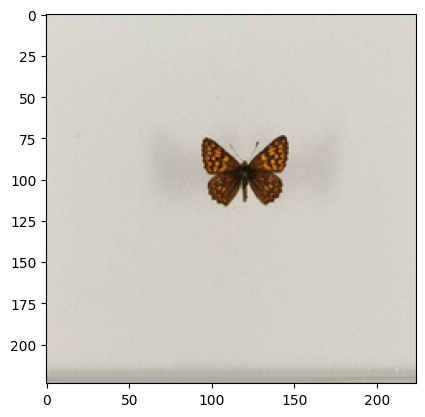

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
53.72% : pinwheel
22.90% : hair_slide
 5.04% : electric_fan
 3.96% : screw
 2.66% : hook

true class: Riodinidae


In [ ]:
row = data.iloc[160,:]

img_path = os.path.join(images_dir, row['image_name'])
hp.predict(input_shape, model, image_path=img_path)
print('\ntrue class:', row[y_col])

In [ ]:
row['image_name']

'2017_04_18R/ETHZ_ENT01_2017_04_18_016580.JPG'

input_shape:  (224, 224)


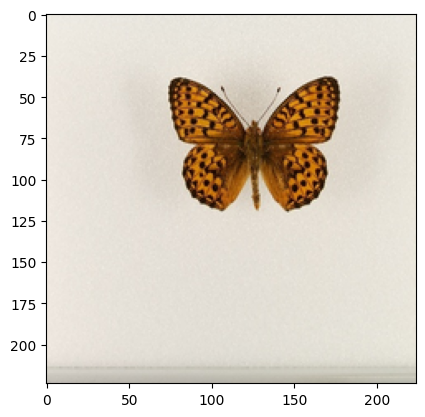

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
33.76% : lycaenid
18.66% : electric_fan
12.10% : hair_slide
 5.32% : pick
 3.52% : leatherback_turtle

true class: Nymphalidae


In [ ]:
row = data.iloc[500,:]

img_path = os.path.join(images_dir, row['image_name'])
hp.predict(input_shape, model, image_path=img_path)
print('\ntrue class:', row[y_col])

In [ ]:
import zipfile
import os
import glob
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import metrics
import seaborn as sns

from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

input_shape:  (224, 224)


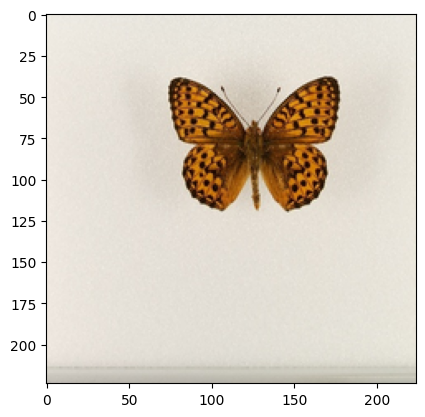

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
33.76% : lycaenid
18.66% : electric_fan
12.10% : hair_slide
 5.32% : pick
 3.52% : leatherback_turtle


In [ ]:
# Load and resize the image using PIL.
img = PIL.Image.open(img_path)
print('input_shape: ', input_shape)
img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

# Plot the image.
plt.imshow(img_resized)
plt.show()

# Convert the PIL image to a numpy-array with the proper shape.
img_array = np.expand_dims(np.array(img_resized), axis=0)

# Use the ResNet50 model to make a prediction.
# This outputs an array with 1000 numbers corresponding to
# the classes of the ImageNet-dataset.
pred = model.predict(img_array)

# Decode the output of the ResNet50 model.
pred_decoded = decode_predictions(pred)[0]

# Print the predictions.
for code, name, score in pred_decoded:
    print("{0:>6.2%} : {1}".format(score, name))

In [ ]:
pred_decoded

[('n02281787', 'lycaenid', 0.33760425),
 ('n03271574', 'electric_fan', 0.18656105),
 ('n03476684', 'hair_slide', 0.12098372),
 ('n03929660', 'pick', 0.053239256),
 ('n01665541', 'leatherback_turtle', 0.03515938)]

input_shape:  (224, 224)


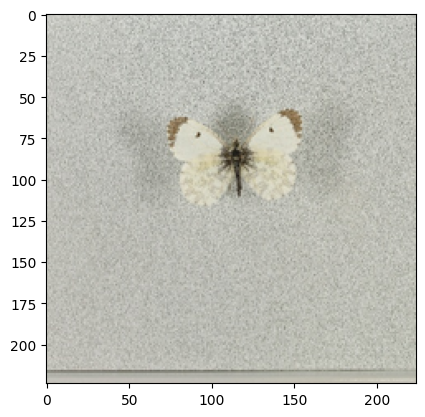

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
14.14% : parachute
13.98% : envelope
 9.79% : Persian_cat
 8.53% : web_site
 8.34% : starfish

true class: Pieridae


In [ ]:
row = data.iloc[200,:]

img_path = os.path.join(images_dir, row['image_name'])
hp.predict(input_shape, model, image_path=img_path)
print('\ntrue class:', row[y_col])

Looks like our vanilla pre-trained ResNet-50 model wont do the job right. In the next notebook, you will learn how to unlock layers of the ResNet-50 model for trainsfer learning. We will also fine-tune the model to improve accuracy. Exciting!

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


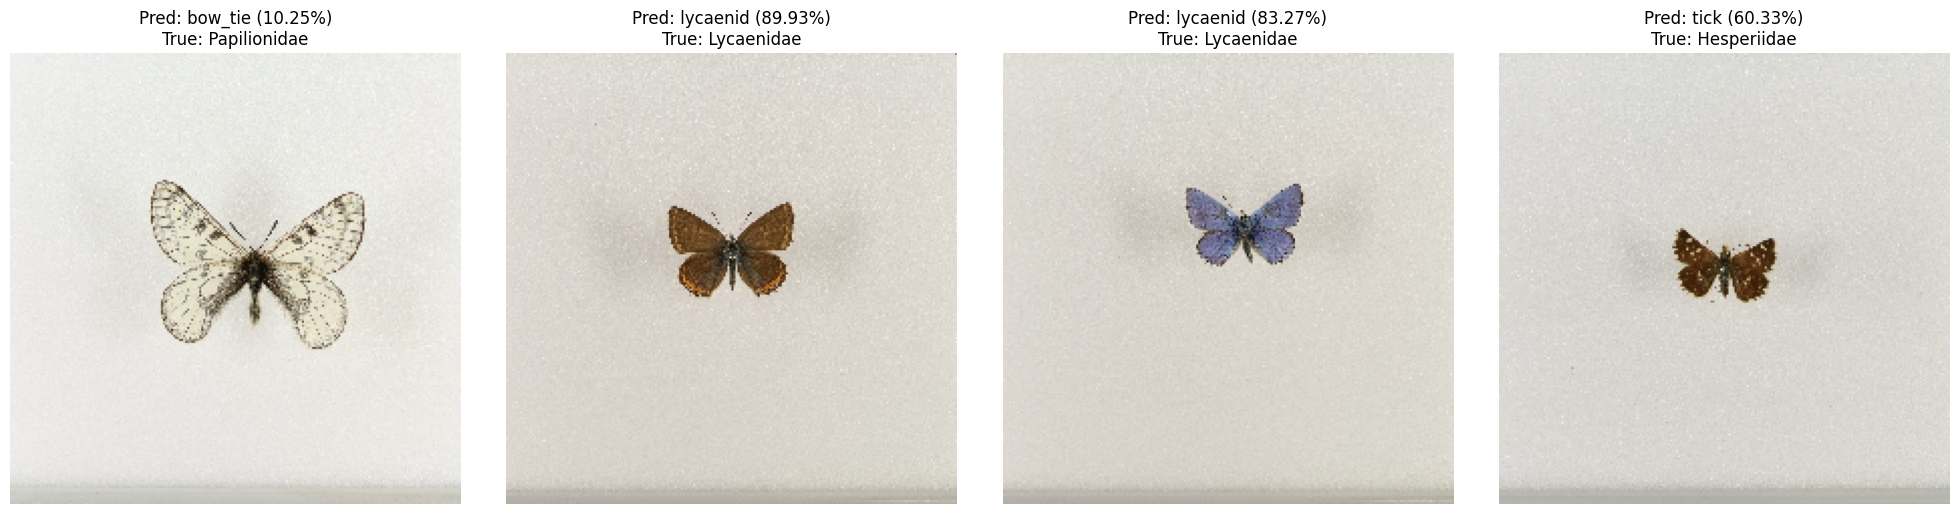

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import os

# Select 4 random images from the dataframe
sampled_data = data.sample(4)

# Create a figure with subplots in a 1x4 grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Iterate over the sampled data to display images, predictions, and true classes
for i, (idx, row) in enumerate(sampled_data.iterrows()):
    img_path = os.path.join(images_dir, row[x_col])
    true_class = row[y_col]

    # Load and process the image
    img = load_img(img_path, target_size=input_shape)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image

    # Predict the image class
    predictions = model.predict(img_array)

    # Get the top-1 predicted class
    pred_decoded = decode_predictions(predictions, top=1)[0][0]
    predicted_class = pred_decoded[1]
    confidence = pred_decoded[2]

    # Plot the image and the prediction
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Pred: {predicted_class} ({confidence:.2%})\nTrue: {true_class}")

# Show the plot
plt.tight_layout()
plt.show()
